In [ ]:
#This is for the initial data load

#BUCKET_NAME = 'sagemaker-us-east-1-023375022819' # replace with your bucket name
#KEY = 'David-Eddy/Fraud/PS_20174392719_1491204439457_log.csv' # replace with your object key

#s3 = boto3.resource('s3')

#try:
#    s3.Bucket(BUCKET_NAME).download_file(KEY,"PS_20174392719_1491204439457_log.csv")
#except botocore.exceptions.ClientError as e:
#    if e.response['Error']['Code'] == "404":
#        print("The object does not exist.")
#    else:
#        raise
  #      s3://sagemaker-us-east-1-023375022819/David-Eddy/Fraud/PS_20174392719_1491204439457_log.csv

In [270]:
%%time

import os
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
region = boto3.Session().region_name

bucket='sagemaker-us-east-1-023375022819' # put your s3 bucket name here, and create s3 bucket
prefix = 'David-Eddy/Fraud'
# customize to your bucket where you have stored the data
#bucket_path = 's3://sagemaker-us-east-1-023375022819/'
bucket_path = 'https://s3.amazonaws.com/sagemaker-us-east-1-023375022819'

CPU times: user 63.5 ms, sys: 4.05 ms, total: 67.6 ms
Wall time: 87.4 ms


In [52]:
bucket_path

'https://s3.amazonaws.com/sagemaker-us-east-1-023375022819'

In [24]:
%%time

import io
import boto3
import random

def data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST):
    data = [l for l in open(FILE_DATA, 'r')]
    train_file = open(FILE_TRAIN, 'w')
    valid_file = open(FILE_VALIDATION, 'w')
    tests_file = open(FILE_TEST, 'w')

    num_of_data = len(data)
    num_train = int((PERCENT_TRAIN/100.0)*num_of_data)
    num_valid = int((PERCENT_VALIDATION/100.0)*num_of_data)
    num_tests = int((PERCENT_TEST/100.0)*num_of_data)

    data_fractions = [num_train, num_valid, num_tests]
    split_data = [[],[],[]]

    rand_data_ind = 0

    for split_ind, fraction in enumerate(data_fractions):
        for i in range(fraction):
            rand_data_ind = random.randint(0, len(data)-1)
            split_data[split_ind].append(data[rand_data_ind])
            data.pop(rand_data_ind)

    for l in split_data[0]:
        train_file.write(l)

    for l in split_data[1]:
        valid_file.write(l)

    for l in split_data[2]:
        tests_file.write(l)

    train_file.close()
    valid_file.close()
    tests_file.close()

def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 17.2 µs


In [49]:
%%time
import urllib.request

# Load the dataset
FILE_DATA = 'boost_dataset3.csv'

#split the downloaded data into train/test/validation files
FILE_TRAIN = 'boost.train'
FILE_VALIDATION = 'boost.validation'
FILE_TEST = 'boost.test'
PERCENT_TRAIN = 70
PERCENT_VALIDATION = 15
PERCENT_TEST = 15
data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST)

#upload the files to the S3 bucket
upload_to_s3(bucket, 'train', FILE_TRAIN)
upload_to_s3(bucket, 'validation', FILE_VALIDATION)
upload_to_s3(bucket, 'test', FILE_TEST)

Writing to s3://sagemaker-us-east-1-023375022819/David-Eddy/Fraud/train/boost.train
Writing to s3://sagemaker-us-east-1-023375022819/David-Eddy/Fraud/validation/boost.validation
Writing to s3://sagemaker-us-east-1-023375022819/David-Eddy/Fraud/test/boost.test
CPU times: user 7min 25s, sys: 467 ms, total: 7min 25s
Wall time: 7min 42s


In [16]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost')

In [61]:
%%time
import boto3
from time import gmtime, strftime

job_name = 'fraud50-xgboost-regression-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

#Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/" + prefix + "/single-xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.4xlarge",
        "VolumeSizeInGB": 5
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "silent":"0",
        "objective":"binary:logistic",
        "num_round":"50"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 3600
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/" + prefix + '/train',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/" + prefix + '/validation',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        }
    ]
}


client = boto3.client('sagemaker', region_name=region)
client.create_training_job(**create_training_params)

import time

status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(30)
    status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)

Training job fraud50-xgboost-regression-2019-03-21-12-27-48
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed
CPU times: user 93.8 ms, sys: 78 µs, total: 93.9 ms
Wall time: 3min


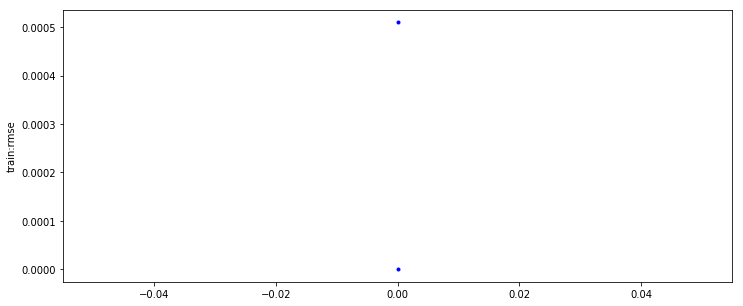

In [68]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

metric_name = 'train:rmse'

#metrics_dataframe = TrainingJobAnalytics(training_job_name=job_name, metric_names=[metric_name]).dataframe()
metrics_dataframe = TrainingJobAnalytics(training_job_name=job_name).dataframe()
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), style='b.', legend=False)
#plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='time', y='value', style='b.', legend=False)
plt.set_ylabel(metric_name);

In [272]:
job_name

'fraud50-xgboost-regression-2019-03-21-12-27-48'

In [58]:
    status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    
    #TrainingJobStatus
    #FailureReason
    print(status)

Completed


In [45]:
df = pd.read_csv("model_dataset50.csv")

In [20]:
status

'Failed'

In [46]:
keep_list = ["isFraud", "amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]

reduced_df = df[keep_list]

In [47]:
reduced_df.shape

(2000000, 6)

In [48]:
reduced_df.to_csv("boost_dataset3.csv",index=False, header=False)

In [70]:
%%time
import boto3
from time import gmtime, strftime

model_name=job_name + '-model'
print(model_name)

info = client.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

fraud50-xgboost-regression-2019-03-21-12-27-48-model
https://s3.amazonaws.com/sagemaker-us-east-1-023375022819/David-Eddy/Fraud/single-xgboost/fraud50-xgboost-regression-2019-03-21-12-27-48/output/model.tar.gz
arn:aws:sagemaker:us-east-1:023375022819:model/fraud50-xgboost-regression-2019-03-21-12-27-48-model
CPU times: user 15.1 ms, sys: 18 µs, total: 15.1 ms
Wall time: 293 ms


In [71]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2019-03-21-12-40-37
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:023375022819:endpoint-config/demo-xgboostendpointconfig-2019-03-21-12-40-37


In [72]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

DEMO-XGBoostEndpoint-2019-03-21-12-40-53
arn:aws:sagemaker:us-east-1:023375022819:endpoint/demo-xgboostendpoint-2019-03-21-12-40-53
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:023375022819:endpoint/demo-xgboostendpoint-2019-03-21-12-40-53
Status: InService
CPU times: user 82.5 ms, sys: 19.9 ms, total: 102 ms
Wall time: 7min 1s


In [75]:
!head -1 boost.test > boost.single.test

In [76]:
runtime_client = boto3.client('runtime.sagemaker', region_name=region)

In [290]:
%%time
import json
from itertools import islice
import math
import struct

file_name = 'boost.single.test' #customize to your test file
with open(file_name, 'r') as f:
    payload = f.read().strip()
response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload[2:])
result = response['Body'].read()
result = result.decode("utf-8")
result = result.split(',')
#result = [round(float(i)) for i in result]
result = [round(float(i)) for i in result]
label = payload.strip(' ').split()[0]
print ('Label: ',label,'\nPrediction: ', result[0])

Label:  0,8717.43,0.0,0.0,0.0,0.0 
Prediction:  0
CPU times: user 13.4 ms, sys: 0 ns, total: 13.4 ms
Wall time: 59 ms


In [305]:
import sys
import math
def do_predict(data_input, endpoint_name, content_type):
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=data_input)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    preds = [float((num)) for num in result]
    preds = [round((num)) for num in preds]

    return preds

def batch_predict(data, endpoint_name, content_type):
    items = len(data)
    arrs = []
    indexes = [i for i, _ in enumerate(range(10000))]
    
    for i in indexes:
        results = do_predict(data[i], endpoint_name, content_type)
        arrs.extend(results)
    
    return(arrs)

In [306]:
%%time
import json
import numpy as np

with open(FILE_TEST, 'r') as f:
    payload = f.read().strip()

labels = [int(line[0]) for line in payload.split('\n')]
test_data = [line[2:] for line in payload.split('\n')]
preds = batch_predict(test_data, endpoint_name, 'text/csv')


CPU times: user 16.7 s, sys: 509 ms, total: 17.2 s
Wall time: 1min 7s


In [307]:
product = 1
for num in preds:
    product = product + num

In [308]:
product

9

In [112]:
len(line[2:])

23

In [281]:
import seaborn as sns

def evaluate_metrics(test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [batch_predict(batch, endpoint_name, 'text/csv') for batch in np.array_split(test_features, 1)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
    test_preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    
    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))

In [ ]:
evaluate_metrics(test_features, test_labels)

In [273]:
%%time
import json
import numpy as np

with open('boost.single.test', 'r') as f:
    payload = f.read().strip()

test_labels = [int(line[0]) for line in payload.split('\n')]
test_features = [line[2:] for line in payload.split('\n')]



CPU times: user 8.3 ms, sys: 0 ns, total: 8.3 ms
Wall time: 7.95 ms


In [282]:
evaluate_metrics(test_features, test_labels)

AttributeError: 'int' object has no attribute 'label'